##  q-related metrics evaluation

Define a pipeline:

In [1]:

import pandas as pd

from pcgvs.extraction import extract_tubes, extract_patches, extract_background, load_tubes_from_pandas_dataframe, load_tubes_with_pandas
from pcgvs.aggregation import solve, add_ss_to_dataframe
from pcgvs.aggregation.relations import RelationsMap
from pcgvs.aggregation.graph import PCG
from pcgvs.aggregation.coloring import color_graph, tubes_starting_time
from pcgvs.synopsis import generate_frames, generate_synopsis
from pcgvs.metrics import FR, CR, OR
from pcgvs.utils import get_video_nframes


def pipeline(tubes_path_csv: str, source: str, q: int):
    
    i = source
    tubes_path = './synopsis/simulation.txt'
    o = './synopsis/'
    interp = True
    t = 4
    
    max_frames = get_video_nframes(source)
    # Create tubes txt file
    trackingdf = pd.read_csv(tubes_path_csv, skiprows=2)
    inserted = set()
    with open(tubes_path, 'w+') as output:
        for idx, (fr, obj, _, _, _, tlx, tly, brx, bry) in trackingdf.iterrows():
            if int(tlx) < 0 or int(tly) < 0: continue
            if int(fr) >= max_frames: continue
            w = int(brx) - int(tlx)
            h = int(bry) - int(tly)
            line = f"{fr//2} {obj} {tlx} {tly} {w} {h} -1 -1 -1 0 \n"
            if line in inserted: continue
            inserted.add(line)
            output.write(line)
    
    # Extraction
    patches_path = extract_patches(source=i, outputdir=o, path_tubes=tubes_path)
    background_path = extract_background(source=i, outputdir=o, path_tubes=tubes_path)
    
    # Aggregation
    dataframe = load_tubes_with_pandas(tubes_path)
    tubes = load_tubes_from_pandas_dataframe(dataframe)
    print('computing the relations')
    relations = RelationsMap(tubes)
    print('Generating the potential collision graph')
    pcg = PCG(tubes, relations)
    print('Applying graph coloring algorithm')
    color_graph(pcg, q)
    starting_times = tubes_starting_time(pcg, q)
    
    # Synopsis
    df = add_ss_to_dataframe(dataframe, tubes, starting_times)
    frames = generate_frames(df, patches_path)
    generate_synopsis(frames, o, 30, background_path, interp)
    print(f'Video synopsis generated with q={q}')
    
    spath = './synopsis/synopsis.avi'
    vpath = './data-simulation/export_20220523_210923.mp4'
    
    # metrics
    _FR = FR(spath, vpath)
    _CR = CR(spath, frames)
    _OR = OR(spath, frames)
    
    return _FR, _CR, _OR

Import the simulations:

In [2]:
import glob

# MODIFY
path_of_all_simulations_csv = "C:\\Users\\Charlemagne\\Desktop\\data_simulation_exported\\*.csv"
path_of_all_sources = "C:\\Users\\Charlemagne\\Desktop\\data_simulation_exported\\*.mp4"
#

all_simulations_csv = glob.glob(path_of_all_simulations_csv)
all_sources = glob.glob(path_of_all_sources)

all_simulations_csv.sort()
all_sources.sort()

Save the results in a json file.

In [ ]:
import json

count = 0

for simulation_csv, source in zip(all_simulations_csv, all_sources):
    metrics_by_q = {}
    for q in [0, 3, 5, 8, 10, 15]:
        print(f'processing pipeline using: tubes={simulation_csv}, source={source}, q={q}\n')
        metrics_by_q[q] = pipeline(simulation_csv, source, q)

    metrics_save = { str(k):v for k, v in metrics_by_q.items() }

    with open(f'./data-simulation/metrics_{count}.json', 'w') as metricsfile:
        json.dump(metrics_save, metricsfile)
    count += 1

processing pipeline using: tubes=C:\Users\Charlemagne\Desktop\data_simulation_exported\tracking_20220706_212236.csv, source=C:\Users\Charlemagne\Desktop\data_simulation_exported\export_20220706_212236.mp4, q=0

C:\Users\Charlemagne\Desktop\data_simulation_exported\export_20220706_212236.mp4 ./synopsis/ ./synopsis/simulation.txt


9001it [00:53, 167.84it/s]                                                                                             


extracting background | frame 2
extracting background | frame 3
extracting background | frame 4
extracting background | frame 5
extracting background | frame 6
extracting background | frame 7
extracting background | frame 8
extracting background | frame 9
extracting background | frame 10
extracting background | frame 11
extracting background | frame 12
extracting background | frame 13
computing the relations


100%|███████████████████████████████████████████████████████████████████████████| 83232/83232 [04:18<00:00, 321.38it/s]


Generating the potential collision graph


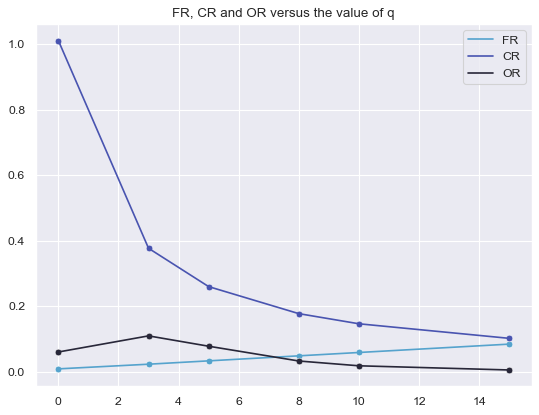

In [37]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_palette("icefire")

Q = [0, 3, 5, 8, 10, 15]

plt.figure(figsize=(8, 6), dpi=80)

for i in range(count):
    with open(f'./data-simulation/metrics_{i}.json', 'r') as metricsfile:
        metrics_by_q = json.load(metricsfile)
        
    qFR = [ metrics_by_q[str(q)][0] for q in Q ]
    qCR = [ metrics_by_q[str(q)][1] for q in Q ]
    qOR = [ metrics_by_q[str(q)][2] for q in Q ]

    sns.lineplot(x=Q, y=qFR, palette=sns.color_palette()[1])
    sns.lineplot(x=Q, y=qCR, palette=sns.color_palette()[3])
    sns.lineplot(x=Q, y=qOR, palette=sns.color_palette()[5])

    sns.scatterplot(x=Q, y=qFR, palette=sns.color_palette()[1])
    sns.scatterplot(x=Q, y=qCR, palette=sns.color_palette()[3])
    sns.scatterplot(x=Q, y=qOR, palette=sns.color_palette()[5])

    plt.title('FR, CR and OR versus the value of q')
    plt.legend(labels=["FR","CR", "OR"])
    plt.show()

In [1]:
import glob
import json

metricsxvideo = glob.glob("/data/tmp-traffik-dataset/*.json")

metricsdictxvideo = {}

for idx, metricpath in enumerate(metricsxvideo):
    with open(metricpath, 'r') as metricfile:
        metricsdictxvideo['T' + str(idx)] = json.load(metricfile)
        

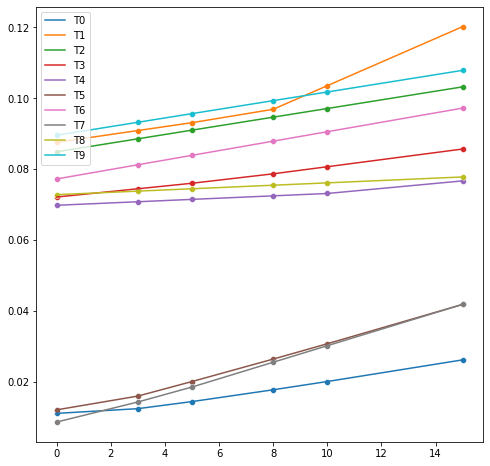

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

Q = [0, 3, 5, 8, 10, 15]

for videotag, videometrics in metricsdictxvideo.items():
    qFR = [ videometrics[str(q)][0] for q in Q ]
    sns.lineplot(x=Q, y=qFR, palette=sns.color_palette()[1])

for videotag, videometrics in metricsdictxvideo.items():
    qFR = [ videometrics[str(q)][0] for q in Q ]
    sns.scatterplot(x=Q, y=qFR, palette=sns.color_palette()[1])
    
    
plt.legend(labels=[k for k in metricsdictxvideo])
plt.savefig('../media/medium_intensity_FR',dpi=300)
plt.show()

<Figure size 432x288 with 0 Axes>

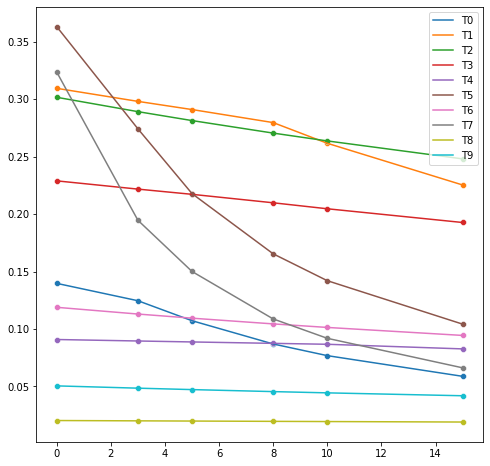

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.clf()
plt.figure(figsize=(8, 8))

Q = [0, 3, 5, 8, 10, 15]

for videotag, videometrics in metricsdictxvideo.items():
    qCR = [ videometrics[str(q)][1] for q in Q ]
    sns.lineplot(x=Q, y=qCR, palette=sns.color_palette()[1])

for videotag, videometrics in metricsdictxvideo.items():
    qCR = [ videometrics[str(q)][1] for q in Q ]
    sns.scatterplot(x=Q, y=qCR, palette=sns.color_palette()[1])
    
    
plt.legend(labels=[k for k in metricsdictxvideo])
plt.savefig("../media/medium_intensity_CR", dpi=300)
plt.show()

<Figure size 432x288 with 0 Axes>

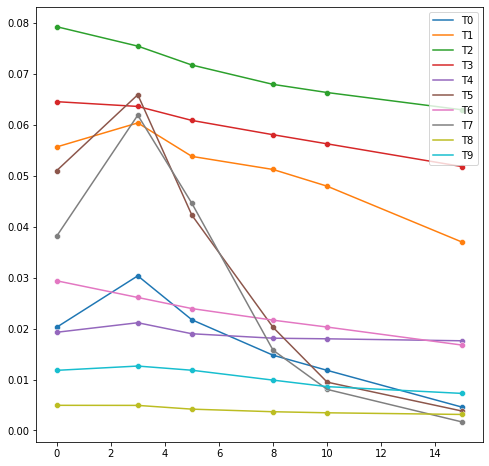

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.clf()
plt.figure(figsize=(8, 8))

Q = [0, 3, 5, 8, 10, 15]

for videotag, videometrics in metricsdictxvideo.items():
    qOR = [ videometrics[str(q)][2] for q in Q ]
    sns.lineplot(x=Q, y=qOR, palette=sns.color_palette()[1])

for videotag, videometrics in metricsdictxvideo.items():
    qOR = [ videometrics[str(q)][2] for q in Q ]
    sns.scatterplot(x=Q, y=qOR, palette=sns.color_palette()[1])
    
    
plt.legend(labels=[k for k in metricsdictxvideo])
plt.savefig("../media/medium_intensity_OR", dpi=300)
plt.show()